In [1]:
import pdb
import traceback

import jax
from jax import numpy as jnp
import optax
import wandb
import equinox as eqx

from common_dl_utils.config_creation import Config
import common_jax_utils as cju

wandb.login()

key = jax.random.PRNGKey(12398)
key_gen = cju.key_generator(key)

import PIL
from PIL import Image
from matplotlib import pyplot as plt

wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: glukanov2000 (glukanov2000-eindhoven-university-of-technology). Use `wandb login --relogin` to force relogin


In [2]:
def load_image_as_array(path:str)->jax.Array:
    file_extension = path.split('.')[-1]
    if file_extension == 'npy':
        return jnp.load(path)
    # it's ostensibly not just a numpy array so let's use PIL
    with PIL.Image.open(path) as pil_image:
        output = jnp.asarray(pil_image)
    return output

def rgb_to_grayscale(rgb_image:jax.Array):
    gray_image = 0.299*rgb_image[:,:,0] + 0.587*rgb_image[:,:,1] + 0.114*rgb_image[:,:,2]
    gray_image = gray_image.astype(jnp.uint8)  
    return gray_image#/255

In [3]:
def image_grads(image: jax.Array)->jax.Array:
    grads = jnp.stack(jnp.gradient(image, axis=(0, 1)), axis=-1)
    grad_y, grad_x = grads[:,:,0], grads[:,:,1]
    grad_x = (grad_x - jnp.min(grad_x)) / (jnp.max(grad_x) - jnp.min(grad_x))
    grad_y = (grad_y - jnp.min(grad_y)) / (jnp.max(grad_y) - jnp.min(grad_y))
    return jnp.stack([grad_x, grad_y], axis=-1)

def image_laplacian(image: jax.Array)->jax.Array:
    grad_x, grad_y = image_grads(image)
    lap_x = jnp.gradient(grad_x, axis=0)  
    lap_y = jnp.gradient(grad_y, axis=1)  
    return lap_x + lap_y

In [4]:
def gray_parrot_grads(path): 
    return image_grads(rgb_to_grayscale(load_image_as_array(path))) 

def gray_parrot(path):
    return rgb_to_grayscale(load_image_as_array(path))

In [5]:
config = Config()

# first we specify what the model should look like
config.architecture = './model_components'  # module containing all relevant classes for architectures
# NB if the classes relevant for creating the model are spread over multiple modules, this is no problem
# let config.architecture be the module that contains the "main" model class, and for all other components just specify the module
# or specify the other modules as default modules to the tools in common_jax_utils.run_utils
config.model_type = 'inr_modules.CombinedINR'

config.model_config = Config()
config.model_config.in_size = 2
config.model_config.out_size = 1
config.model_config.terms = [  # CombinedINR uses multiple MLPs and returns the sum of their outputs. These 'terms' are the MLPs
    ('inr_modules.MLPINR.from_config',{
        'hidden_size': 256,
        'num_layers': 5,
        'layer_type': 'inr_layers.SirenLayer',
        'num_splits': 1,
        'activation_kwargs': {'w0': 30.}, # TODO experiment with this
        'initialization_scheme':'initialization_schemes.siren_scheme',
        'initialization_scheme_kwargs': {'w0': 30.}
        #'positional_encoding_layer': ('inr_layers.ClassicalPositionalEncoding.from_config', {'num_frequencies': 10}),
    }),
    # ('inr_modules.MLPINR.from_config',{
    #     'hidden_size': 1024,
    #     'num_layers': 2,
    #     'num_splits': 1,
    #     'layer_type': 'inr_layers.GaussianINRLayer',
    #     'use_complex': False,
    #     'activation_kwargs': {'inverse_scale': 1},
    # })
]
config.model_config.post_processor = ("./inr_utils", "misc.get_first_element")

In [6]:
# create the model
try:
    inr = cju.run_utils.get_model_from_config_and_key(
        prng_key=next(key_gen),
        config=config,
        model_sub_config_name_base='model',
        add_model_module_to_architecture_default_module=False, # since the model is already in the default module specified by 'architecture',
    )
except Exception as e:
    traceback.print_exc()
    print(e)
    print('\n')
    pdb.post_mortem()

In [7]:
# inr

# supervising with gradients

In [8]:
def sample_coordinates(key, image, num_samples):
    coordinates = jax.random.randint(key, (num_samples, 2), minval=0, maxval=jnp.array([image.shape[0], image.shape[1]]))
    return coordinates

def scale_coordinates(height_image, width_image, coordinates):
    x = coordinates[:, 0]  
    y = coordinates[:, 1]  
    x_max = height_image-1
    y_max = width_image-1
    x_normalized = x/x_max
    y_normalized = y/y_max
    return jnp.stack([x_normalized, y_normalized], axis=1)

def gradient_loss(inr, gt_grads, coordinates):
    height_image = gt_grads.shape[0]
    width_image = gt_grads.shape[1]
    inr_grad = eqx.filter_grad(inr)

    # coordinates = coordinates.astype(jnp.int32)
    gt = gt_grads[coordinates[:,0], coordinates[:,1]]

    scaled_coords = scale_coordinates(height_image, width_image, coordinates)
    preds = jax.vmap(inr_grad)(scaled_coords)

    return jnp.sum(jnp.linalg.norm(preds - gt, axis=-1))

# def laplacian_loss(gt_lap, coordinates):
    grad = jax.vmap(inr_grad)(coordinates)    
    lap_x, lap_y = jnp.gradient(grad, axis=(0,1))  
    inr_lap = lap_x + lap_y

    coordinates = coordinates.astype(jnp.int32)
    gt = gt_lap[coordinates[:,0], coordinates[:,1]]
    
    return jnp.sum(jnp.linalg.norm(inr_lap - gt, axis=-1))

# def regular_loss(inr, gt, coordinates):
    preds = jax.vmap(inr)(coordinates)
    coordinates = coordinates.astype(jnp.int32)
    gt = gt[coordinates[:,0], coordinates[:,1]]
    return jnp.sum(jnp.linalg.norm(preds - gt, axis=-1))

In [9]:
# scale_coordinates(1356, 2040, sample_coordinates(next(key_gen), gray_parrot('example_data/parrot.png'), 10))

In [10]:
def train(inr, gt_grads, nr_steps, nr_coordinates, key_generator):

    optimizer = optax.adam(learning_rate = 1e-5)
    opt_state = optimizer.init(eqx.filter(inr, eqx.is_array))

    @eqx.filter_jit
    def train_step(inr, opt_state, coordinates):
        loss, grad = eqx.filter_value_and_grad(gradient_loss)(inr, gt_grads, coordinates)
        updates, opt_state = optimizer.update(grad, opt_state)
        inr = eqx.apply_updates(inr, updates)
        return inr, opt_state, loss

    losses = nr_steps*[None]
    for step in range(nr_steps):
        coordinates = sample_coordinates(next(key_generator), gt_grads, nr_coordinates)
        inr, opt_state, loss = train_step(inr, opt_state, coordinates)
        losses[step] = loss
        
        # if step % 100 == 0: 
        #     print(losses[step])
    return inr, losses

In [11]:
inr, losses = train(
      inr, 
      gray_parrot_grads('example_data/parrot.png')[300:600, 550:800], 
      nr_steps=2000,
      nr_coordinates=1000, 
      key_generator=key_gen
      )

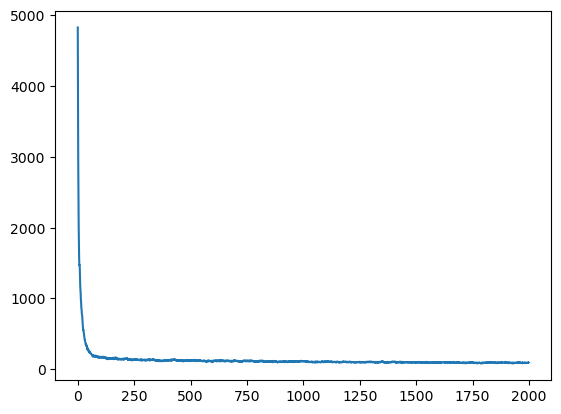

In [12]:
plt.plot(losses)
plt.show()

In [13]:
all_coordinates = jnp.stack(jnp.meshgrid(jnp.arange(0, 1356, 1), jnp.arange(0, 2040, 1), sparse=False, indexing='ij'), axis=-1)
all_coordinates_flat = jax.lax.reshape(all_coordinates, (all_coordinates.shape[0]*all_coordinates.shape[1], 2))
all_coordinates_scaled = scale_coordinates(1356, 2040, all_coordinates_flat)


corner_parrot = all_coordinates[300:600, 550:800]
corner_parrot_flat = jax.lax.reshape(corner_parrot, (corner_parrot.shape[0]*corner_parrot.shape[1], 2))
corner_parrot_scaled = scale_coordinates(300, 250, corner_parrot_flat)

# jnp.reshape(corner_parrot_flat, corner_parrot.shape) == corner_parrot

In [14]:
preds = jax.vmap(inr)(corner_parrot_scaled)
preds = jnp.reshape(preds, corner_parrot.shape[:-1])

# preds = jax.vmap(inr)(all_coordinates_scaled)
# preds = jnp.reshape(preds, all_coordinates.shape[:-1])

In [15]:
from inr_utils.images import make_linearly_interpolated_image
image_func = make_linearly_interpolated_image(
    jnp.expand_dims(load_image_as_array('example_data/gray_parrot.png'),axis=-1))
auto_grad = eqx.filter_grad(lambda x: image_func(x).squeeze())

my_grad = gray_parrot_grads('example_data/parrot.png')
# my_grad_2 = image_grads(jnp.reshape(jax.vmap(image_func)(all_coordinates_flat), 
#             (all_coordinates.shape[0],all_coordinates.shape[1])))

In [49]:
gray_parrot('example_data/parrot.png')[5,5], image_func(jnp.array([5,5]))

(Array(84, dtype=uint8), Array([250.], dtype=float32))

In [17]:
parrot = gray_parrot('example_data/parrot.png')[300:600, 550:800]
diff = preds - parrot
diff = diff.flatten()
mse = (diff @ diff.transpose()) / all_coordinates_flat.shape[0]
mse

Array(280.81058, dtype=float32)

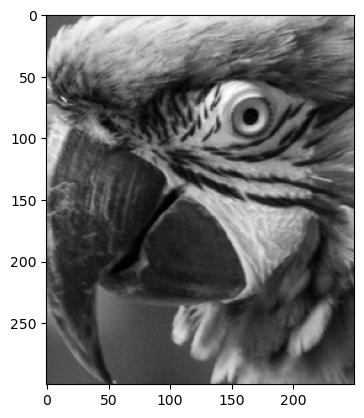

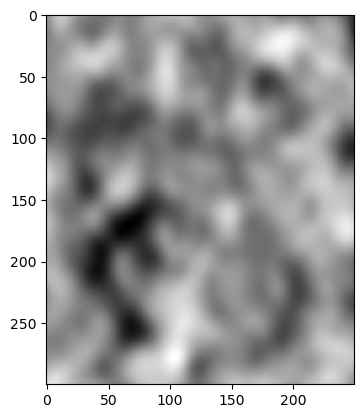

In [18]:
plt.imshow(gray_parrot('example_data/parrot.png')[300:600, 550:800], cmap='gray')
plt.show()
plt.imshow(preds, cmap='gray')
plt.show()

In [38]:
image = load_image_as_array('example_data/parrot.png')

fft_image = jnp.fft.fft2(image)
fft_shifted = jnp.fft.fftshift(fft_image)  

power_spectrum = jnp.abs(fft_shifted) ** 2
power_spectrum = power_spectrum[:,:,0]+power_spectrum[:,:,1]+power_spectrum[:,:,2]

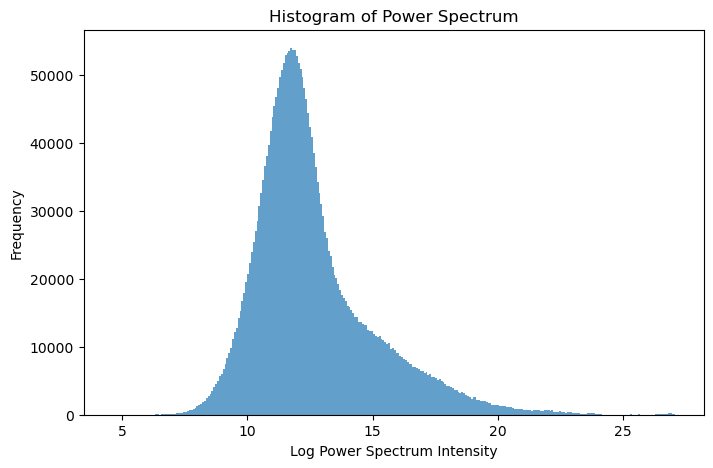

In [39]:

plt.figure(figsize=(8, 5))
plt.hist(jnp.log(power_spectrum.flatten()), bins=300, alpha=0.7) 
plt.xlabel("Log Power Spectrum Intensity")
plt.ylabel("Frequency")
plt.title("Histogram of Power Spectrum")
plt.show()